In [1]:
import wfdb
import numpy as np    
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from scipy import signal
import glob

# Data Collection

In [2]:
def visualizeSignal(path):
    # Load the ECG signal data from the PhysioNet database
    record = wfdb.rdrecord(path, sampto=250)
    signal = record.p_signal[:, 0]

    # Plot the original ECG signal
    plt.figure(figsize=(10, 4))
    plt.plot(signal)
    plt.title('Original ECG Signal')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

Case from MIT-BIH NSRDB


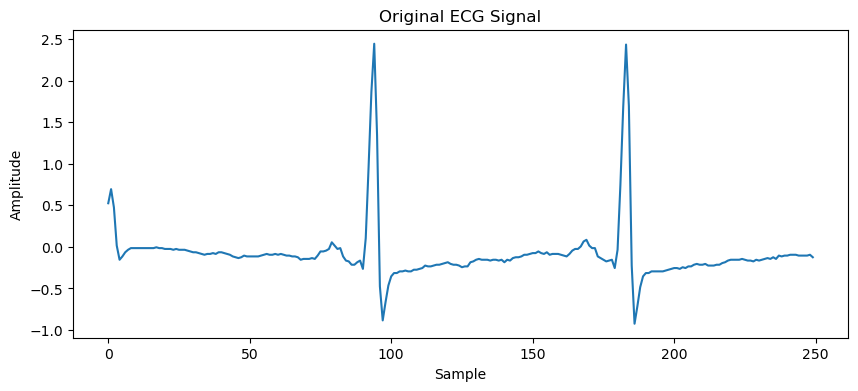

Case from St INCARTDB DB


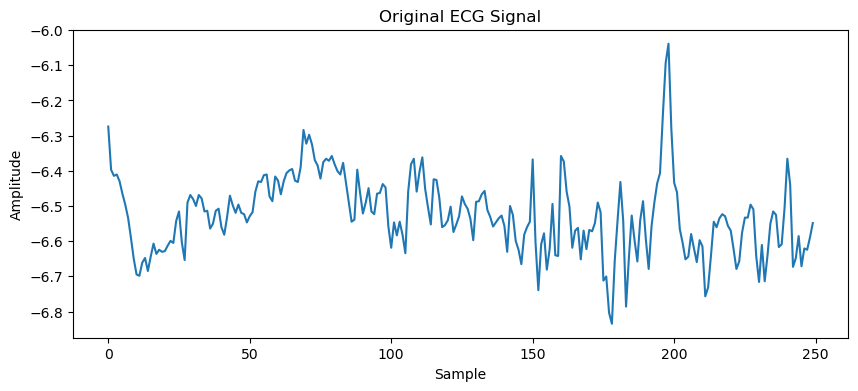

Case from PTBDB


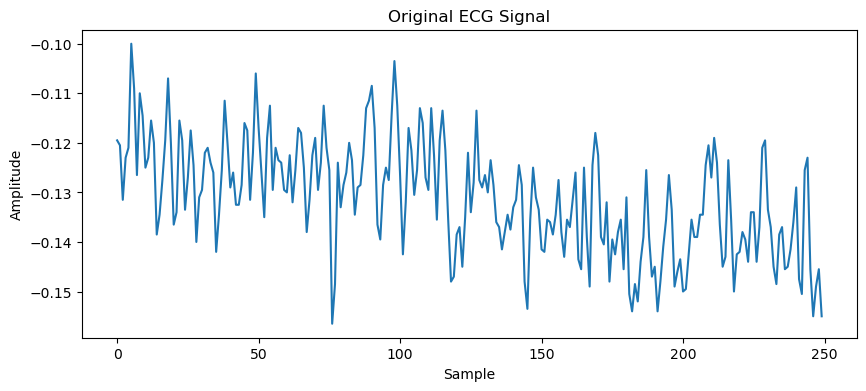

Case from BIDMC CHFDB


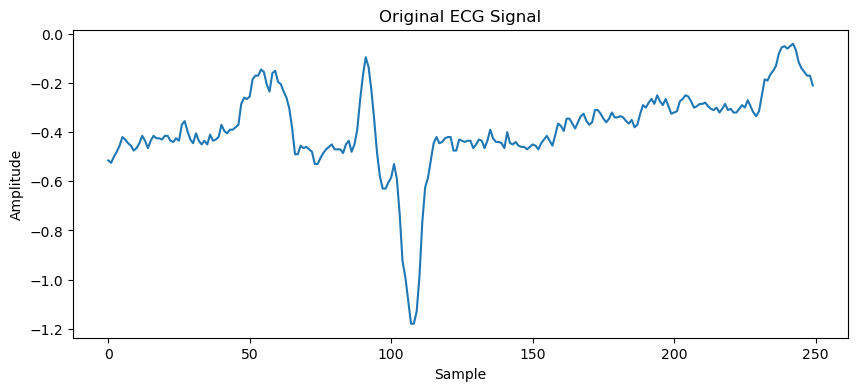

In [3]:
print("Case from MIT-BIH NSRDB")
Normal = visualizeSignal('data/raw/mit-bih-normal-sinus-rhythm-database-1.0.0/mit-bih-normal-sinus-rhythm-database-1.0.0/17453')

print("Case from St INCARTDB DB")
CAD = visualizeSignal('data/raw/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0/files/I39')

print("Case from PTBDB") 
MI = visualizeSignal('data/raw/ptb-diagnostic-ecg-database-1.0.0/ptb-diagnostic-ecg-database-1.0.0/patient007/s0038lre')

print("Case from BIDMC CHFDB")
CHF = visualizeSignal('data/raw/bidmc-congestive-heart-failure-database-1.0.0/files/chf07')

In [4]:
# To check needing of filtering in preprocessing
# You can also measure the signal-to-noise ratio (SNR) of the ECG signal, 
# which is a metric used to quantify the level of noise in the signal relative to the desired signal. 
# If the SNR is low, then filtering may be necessary to improve the accuracy of subsequent analyses. 
# Additionally, if the signal is to be used for automatic classification tasks, 
# filtering may be necessary to remove any noise that could interfere with the classification process.

In [5]:
def checkFiltering(path):
    # Load ECG signal 
    record = wfdb.rdrecord(path)
    ecg_signal = record.p_signal[:, 0]

    # Calculate RMS of signal and noise
    signal_rms = np.sqrt(np.mean(ecg_signal**2))
    noise_rms = np.sqrt(np.mean((ecg_signal - signal.medfilt(ecg_signal))**2))

    # Calculate SNR
    snr = 20*np.log10(signal_rms / noise_rms)

    # Print SNR
    print("Signal-to-Noise Ratio (SNR): {:.2f} dB".format(snr))
    
    return snr

In [6]:
print("Case from MIT-BIH NSRDB")
print("not need" if checkFiltering('data/raw/mit-bih-normal-sinus-rhythm-database-1.0.0/mit-bih-normal-sinus-rhythm-database-1.0.0/17453')>=10 else "need")

print("Case from St INCARTDB DB")
print("not need" if checkFiltering('data/raw/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0/files/I39')>=10 else "need")

print("Case from PTBDB")
print("not need" if checkFiltering('data/raw/ptb-diagnostic-ecg-database-1.0.0/ptb-diagnostic-ecg-database-1.0.0/patient007/s0038lre')>=10 else "need")

print("Case from BIDMC CHFDB")
print("not need" if checkFiltering('data/raw/bidmc-congestive-heart-failure-database-1.0.0/files/chf07')>=10 else "need")

Case from MIT-BIH NSRDB
Signal-to-Noise Ratio (SNR): 14.85 dB
not need
Case from St INCARTDB DB
Signal-to-Noise Ratio (SNR): 52.84 dB
not need
Case from PTBDB
Signal-to-Noise Ratio (SNR): 28.78 dB
not need
Case from BIDMC CHFDB
Signal-to-Noise Ratio (SNR): 34.15 dB
not need


In [7]:
def resampleSignal(path, channels):
    # Resample the ECG signal to a consistent sampling rate

    # Load the ECG signal data from the PhysioNet database
    record = wfdb.rdrecord(path, channels= channels)
    signal = record.p_signal[:, 0]

    fs = record.fs
    new_fs = 250

    # Create a time array for the original signal
    t_orig = np.arange(signal.size) / fs

    # Create a time array for the resampled signal
    t_new = np.arange(0, t_orig[-1], 1 / new_fs)

    # Resample the ECG signal using linear interpolation
    f = interpolate.interp1d(t_orig, signal)
    resampled_signal = f(t_new)

    # Plot the resampled ECG signal
    # plt.figure(figsize=(10, 4))
    # plt.plot(resampled_signal[:250])
    # plt.title('Resampled ECG Signal')
    # plt.xlabel('Sample')
    # plt.ylabel('Amplitude')
    # plt.show()
    
    return resampled_signal

In [8]:
# print("Case from MIT-BIH NSRDB")
# Normal = resampleSignal('data/raw/mit-bih-normal-sinus-rhythm-database-1.0.0/mit-bih-normal-sinus-rhythm-database-1.0.0/17453')

# print("Case from St INCARTDB DB")
# CAD = resampleSignal('data/raw/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0/files/I39')

# print("Case from PTBDB") 
# MI = resampleSignal('data/raw/ptb-diagnostic-ecg-database-1.0.0/ptb-diagnostic-ecg-database-1.0.0/patient007/s0038lre')

# print("Case from BIDMC CHFDB")
# CHF = resampleSignal('data/raw/bidmc-congestive-heart-failure-database-1.0.0/files/chf07')

In [9]:
def pan_tompkins(ecg_signal, fs):
    """
    Detect R-peaks in an ECG signal using the Pan-Tompkins algorithm.

    Parameters:
        ecg_signal (numpy.ndarray): The ECG signal.
        fs (float): The sampling rate of the ECG signal.

    Returns:
        r_peaks (numpy.ndarray): An array of indices corresponding to the R-peaks in the ECG signal.
    """
    # Define filter parameters
    lowcut = 5
    highcut = 15
    order = 2

    # Apply band-pass filter to remove unwanted frequencies
    nyquist = 0.5 * fs
    b, a = signal.butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')
    filtered_ecg_signal = signal.filtfilt(b, a, ecg_signal)

    # Differentiate the signal
    diff_ecg_signal = np.diff(filtered_ecg_signal)

    # Square the differentiated signal
    squared_diff_ecg_signal = diff_ecg_signal**2

    # Apply moving average filter to smooth the signal
    window_size = int(0.15 * fs)
    weights = np.ones(window_size) / window_size
    smoothed_squared_diff_ecg_signal = np.convolve(squared_diff_ecg_signal, weights, mode='same')

    # Find the R-peaks
    r_peaks = signal.find_peaks(smoothed_squared_diff_ecg_signal, distance=int(0.2 * fs))[0]

    return r_peaks


In [10]:
# peaks = pan_tompkins(resampled_signal, 250)

In [11]:
def SegmentSignal(peaks, resampled_signal):
    # Segment ECG signal into individual heartbeats
    window_size = 200
    heartbeats = []
    for i in range(len(peaks)):
        start = peaks[i] - int(window_size/2)
        end = peaks[i] + int(window_size/2)
        if start < 0 or end > len(resampled_signal):
            continue
        heartbeat = resampled_signal[start:end]
        heartbeats.append(heartbeat)

    # Plot individual heartbeats
    # fig, axs = plt.subplots(3, figsize=(8, 6), sharex=True, sharey=True)
    # for i in range(3):
    #     axs[i].plot(heartbeats[i])
    #     axs[i].set_title("Heartbeat {}".format(i+1))
    # plt.show()
    
    return heartbeats

In [12]:
# heartbeats = SegmentSignal(peaks, resampled_signal)

In [13]:
def getheartbeats(path, channels):
    normal_case = resampleSignal(path, [channels[0]])
    peaks = pan_tompkins(normal_case, 250)
    beats1 = SegmentSignal(peaks, normal_case)
    
    normal_case = resampleSignal(path, [channels[1]])
    peaks = pan_tompkins(normal_case, 250)
    beats2 = SegmentSignal(peaks, normal_case)
    
    heartbeats = [np.concatenate((beat1_elem, beat2_elem), axis=0) for beat1_elem, beat2_elem in zip(beats1, beats2)]
    return heartbeats

In [ ]:
def generateData(files, channels):
    data = []
    for f in normal_files:
        data += getheartbeats(f'data/raw/mit-bih-normal-sinus-rhythm-database-1.0.0/mit-bih-normal-sinus-rhythm-database-1.0.0/{f}', [0,1])

In [16]:
normal_train = []
normal_test = []
normal_files_train = [['16265'], ['16272'], ['16273'], ['16420'],
                      ['16483'], ['16539'], ['16773'], ['16786'],
                      ['16795'], ['17052']]
normal_files_test = ['19090', '19093', '19140', '19830']

In [17]:
# train
for t in normal_files_train:
    data = []
    for c in t:
        data += getheartbeats(f'data/raw/mit-bih-normal-sinus-rhythm-database-1.0.0/mit-bih-normal-sinus-rhythm-database-1.0.0/{c}', [0,1])
    normal_train.append(data)
for ts in normal_files_test:
    normal_test += getheartbeats(f'data/raw/mit-bih-normal-sinus-rhythm-database-1.0.0/mit-bih-normal-sinus-rhythm-database-1.0.0/{ts}', [0,1])        

In [18]:
len(normal_train[0])*10+len(normal_test)

4497170

In [20]:
len(normal_train)

10

In [21]:
CAD_train = []
CAD_test = []
CAD_files_train = [['I01'], ['I02'], ['I20'], ['I21'],
                      ['I22'], ['I35'], ['I36'], ['I37'],
                      ['I38'], ['I39']]
CAD_files_test = ['I44', 'I45', 'I46', 'I57',
                  'I58', 'I72', 'I73']

In [23]:
# train
for t in CAD_files_train:
    data = []
    for c in t:
        data += getheartbeats(f'data/raw/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0/files/{c}', [1,6])
    CAD_train.append(data)
for ts in CAD_files_test:
    CAD_test += getheartbeats(f'data/raw/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0/files/{ts}', [1,6]) 

In [24]:
len(CAD_train[0])*10+len(CAD_test)

108470

In [26]:
for i in range(10):
    print(len(CAD_train[i]))

6382
6089
6259
6161
6429
6659
6187
6712
6481
6235


In [63]:
MI = []
folder_path = 'data/raw/ptb-diagnostic-ecg-database-1.0.0/ptb-diagnostic-ecg-database-1.0.0/*/*.dat'
MI_files = glob.glob(folder_path) 

In [64]:
train_files_num = int(len(MI_files)*.8/10)*10
test_files_num = len(MI_files) - int(len(MI_files)*.8/10)*10

In [65]:
MI_train = []
MI_test = []

In [68]:
# train files
for i in range(0,train_files_num, int(train_files_num*.1)):
    data = []
    for c in range(i, i+int(train_files_num*.1)):
        data += getheartbeats(MI_files[c][:-4], [1,6])
    MI_train.append(data)

# test files
for j in range(train_files_num, train_files_num+test_files_num):
    MI_test  += getheartbeats(MI_files[j][:-4], [1,6])

In [70]:
for i in range(10):
    print(len(MI_train[i]))

11156
11495
11388
11552
11575
11528
11415
11776
11529
11382


In [72]:
len(MI_test)

27748

In [73]:
CHF = []
folder_path = 'data/raw/bidmc-congestive-heart-failure-database-1.0.0/files/*.dat'
CHF_files = glob.glob(folder_path) 

In [74]:
len(CHF_files)

15

In [75]:
CHF_train = []
CHF_test = []

In [76]:
# train files
for i in range(10):
    CHF_train.append(getheartbeats(CHF_files[i][:-4], [0,1]))

# test files
for j in range(10, len(CHF_files)):
    CHF_test  += getheartbeats(MI_files[j][:-4], [0,1])

In [77]:
for i in range(10):
    print(len(CHF_train[i]))

237191
246305
246345
257528
237000
246771
238540
269181
248029
290778


In [78]:
len(CHF_train)

10

In [80]:
min_train = [] 
for k in range(10):
    min_train.append(min([len(normal_train[k]), len(CAD_train[k]), len(MI_train[k]), len(CHF_train[k])]))
min_train

[6382, 6089, 6259, 6161, 6429, 6659, 6187, 6712, 6481, 6235]

In [81]:
min(min_train)

6089

In [82]:
def makeBalance(arr, className, minVal):
    y = [className] * minVal
    df = pd.DataFrame(arr[:minVal]) 
    df["output"] = y
    return df

In [83]:
for k in range(10):
    normal_train[k] = makeBalance(normal_train[k], 'Normal', min(min_train))
    CAD_train[k]    = makeBalance(CAD_train[k],    'CAD',    min(min_train))
    MI_train[k]     = makeBalance(MI_train[k],     'MI',     min(min_train))
    CHF_train[k]    = makeBalance(CHF_train[k],    'CHF',    min(min_train))

In [84]:
min_test = min([len(normal_test), len(CAD_test), len(MI_test), len(CHF_test)])

In [85]:
normal_test = makeBalance(normal_test, 'Normal', min_test)
CAD_test    = makeBalance(CAD_test,    'CAD',    min_test)
MI_test     = makeBalance(MI_test,     'MI',     min_test)
CHF_test    = makeBalance(CHF_test,    'CHF',    min_test)

In [87]:
for k in range(10):
    print(len(normal_train[k]), len(CAD_train[k]), len(MI_train[k]), len(CHF_train[k]))

6089 6089 6089 6089
6089 6089 6089 6089
6089 6089 6089 6089
6089 6089 6089 6089
6089 6089 6089 6089
6089 6089 6089 6089
6089 6089 6089 6089
6089 6089 6089 6089
6089 6089 6089 6089
6089 6089 6089 6089


In [110]:
normal_train[4].head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,output
0,0.44164,0.41092,0.37620,0.31988,0.26148,0.19492,0.13860,0.11300,0.07980,0.02860,...,-0.12636,-0.11612,-0.12412,-0.13436,-0.13980,-0.14492,-0.13996,-0.13500,-0.13500,Normal
1,0.04828,0.04636,0.03100,0.01876,0.00852,0.01172,0.02196,0.01060,-0.00988,-0.04956,...,-0.11524,-0.08100,-0.05540,-0.02252,0.03892,0.09140,0.11700,-0.01700,-0.52900,Normal
2,0.42716,0.42060,0.41548,0.36860,0.31740,0.26132,0.20500,0.15380,0.10236,0.04604,...,-0.09500,-0.09500,-0.09500,-0.09500,-0.09500,-0.09500,-0.09124,-0.08612,-0.08500,Normal
3,-0.00340,0.00172,-0.00420,-0.02980,-0.03668,-0.01620,-0.00964,-0.01988,-0.05828,-0.12484,...,0.04068,0.08212,0.12308,0.17380,0.22500,-0.26652,-0.76140,-1.32460,-1.83644,Normal
4,0.38724,0.37636,0.36100,0.33940,0.31380,0.28484,0.25412,0.21620,0.17524,0.12660,...,-0.08348,-0.07836,-0.07676,-0.08188,-0.08500,-0.08500,-0.08724,-0.09236,-0.09252,Normal


In [111]:
CAD_train[4].head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,output
0,1.602417,1.603733,1.606350,1.595767,1.587500,1.589833,1.594117,1.593267,1.591667,1.586067,...,1.208767,1.213050,1.216667,1.215883,1.213400,1.215650,1.212500,1.212500,1.212500,CAD
1,1.524117,1.523833,1.533333,1.534567,1.534800,1.526233,1.520833,1.525933,1.531517,1.529167,...,1.127450,1.131733,1.133333,1.130533,1.129167,1.132200,1.130183,1.132433,1.133333,CAD
2,1.521667,1.526383,1.519200,1.516667,1.513533,1.509250,1.518433,1.527800,1.521967,1.517117,...,1.133183,1.150800,1.199267,1.175233,1.051667,0.842900,0.550983,0.257733,0.007717,CAD
3,1.480767,1.483333,1.487000,1.497517,1.504167,1.510717,1.514367,1.512500,1.520100,1.532950,...,1.104983,1.105167,1.100883,1.103400,1.104167,1.100533,1.100000,1.103867,1.108150,CAD
4,1.583033,1.574467,1.567050,1.573333,1.591667,1.590200,1.586733,1.603867,1.626417,1.662567,...,1.125667,1.130733,1.143800,1.179883,1.208367,1.136250,0.980233,0.743483,0.435133,CAD


In [112]:
MI_train[4].head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,output
0,1.0210,0.9825,0.9930,0.9985,0.9940,0.9795,0.9765,0.9875,0.9700,0.9805,...,0.1055,0.1360,0.1420,0.1535,0.1600,0.1630,0.1650,0.1555,0.1545,MI
1,1.0335,1.0480,1.0540,1.0625,1.0625,1.0510,1.0465,1.0585,1.0750,1.0735,...,0.2740,0.2725,0.2805,0.2790,0.2765,0.2725,0.2780,0.2865,0.2870,MI
2,1.0955,1.1030,1.0960,1.1105,1.0940,1.0945,1.1050,1.0835,1.1000,1.0990,...,0.3540,0.3405,0.3390,0.3360,0.3465,0.3450,0.3510,0.3600,0.3525,MI
3,1.1100,1.1215,1.1235,1.1170,1.1125,1.1115,1.1245,1.1210,1.1145,1.1115,...,0.3470,0.3740,0.3845,0.3940,0.3925,0.4025,0.4040,0.4035,0.4010,MI
4,1.1155,1.0945,1.0775,1.0870,1.0810,1.0780,1.0820,1.0605,1.0605,1.0615,...,0.5270,0.5280,0.5260,0.5385,0.5350,0.5425,0.5465,0.5510,0.5540,MI


In [113]:
CHF_train[4].head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,output
0,-0.570,-0.555,-0.535,-0.540,-0.540,-0.530,-0.525,-0.520,-0.510,-0.500,...,-0.36,-0.335,-0.295,-0.270,-0.235,-0.220,-0.180,-0.135,-0.135,CHF
1,-0.520,-0.495,-0.480,-0.445,-0.405,-0.410,-0.390,-0.370,-0.330,-0.295,...,-0.24,-0.255,-0.240,-0.260,-0.265,-0.280,-0.325,-0.355,-0.400,CHF
2,0.005,0.045,0.065,0.095,0.085,0.090,0.080,0.075,0.040,0.020,...,0.08,0.100,0.110,0.120,0.110,0.115,0.135,0.120,0.120,CHF
3,-0.185,-0.185,-0.160,-0.165,-0.145,-0.130,-0.110,-0.080,-0.080,-0.060,...,-0.08,-0.085,-0.085,-0.085,-0.095,-0.125,-0.165,-0.190,-0.230,CHF
4,-0.050,-0.045,-0.020,-0.050,-0.025,-0.035,-0.040,-0.045,-0.045,-0.010,...,0.18,0.190,0.170,0.180,0.175,0.175,0.195,0.205,0.225,CHF


In [114]:
dfs_cross_val = []
for k in range(10):
    dfs_cross_val.append(pd.concat([normal_train[k], CAD_train[k], MI_train[k], CHF_train[k]])) 

In [122]:
for k in range(10):
    print(dfs_cross_val[k].output.value_counts())

Normal    6089
CAD       6089
MI        6089
CHF       6089
Name: output, dtype: int64
Normal    6089
CAD       6089
MI        6089
CHF       6089
Name: output, dtype: int64
Normal    6089
CAD       6089
MI        6089
CHF       6089
Name: output, dtype: int64
Normal    6089
CAD       6089
MI        6089
CHF       6089
Name: output, dtype: int64
Normal    6089
CAD       6089
MI        6089
CHF       6089
Name: output, dtype: int64
Normal    6089
CAD       6089
MI        6089
CHF       6089
Name: output, dtype: int64
Normal    6089
CAD       6089
MI        6089
CHF       6089
Name: output, dtype: int64
Normal    6089
CAD       6089
MI        6089
CHF       6089
Name: output, dtype: int64
Normal    6089
CAD       6089
MI        6089
CHF       6089
Name: output, dtype: int64
Normal    6089
CAD       6089
MI        6089
CHF       6089
Name: output, dtype: int64


In [129]:
for k in range(10):
    dfs_cross_val[k].to_csv(f'train_data{k}.csv.gz', index=False, compression='gzip')

In [90]:
print(len(normal_test), len(CAD_test), len(MI_test), len(CHF_test))

1993 1993 1993 1993


In [119]:
normal_test.output.value_counts()

Normal    1993
Name: output, dtype: int64

In [94]:
len(normal_test)

1993

In [96]:
normal_test.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,output
0,-0.48500,-0.48500,-0.4846,-0.47948,-0.47500,-0.47500,-0.47412,-0.46900,-0.46500,-0.46500,...,0.16204,0.15692,0.15500,0.15500,0.15500,0.1550,0.15132,0.14620,0.14108,Normal
1,0.44484,0.43972,0.4346,0.42948,0.42500,0.42500,0.42500,0.42500,0.42388,0.41876,...,-0.28692,-0.28500,-0.28500,-0.27812,-0.26788,-0.2650,-0.26500,-0.26500,-0.26500,Normal
2,-0.48500,-0.48500,-0.4850,-0.48460,-0.47948,-0.47500,-0.47500,-0.47412,-0.46900,-0.46388,...,0.16204,0.15692,0.15500,0.15500,0.15500,0.1550,0.15132,0.14620,0.14108,Normal
3,0.43500,0.43500,0.4350,0.43500,0.43500,0.43436,0.42924,0.42412,0.41900,0.41500,...,-0.30500,-0.30180,-0.29668,-0.29156,-0.28644,-0.2850,-0.28500,-0.28108,-0.27596,Normal
4,-0.48484,-0.47972,-0.4750,-0.47500,-0.47436,-0.46924,-0.46500,-0.46500,-0.46388,-0.45876,...,0.13500,0.13500,0.13500,0.13500,0.13132,0.1262,0.12108,0.11596,0.11084,Normal


In [98]:
CAD_test.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,output
0,-0.888418,-0.876412,-0.848444,-0.826497,-0.781046,-0.725052,-0.667765,-0.583373,-0.484235,-0.388235,...,0.439444,0.432654,0.432412,0.441686,0.444948,0.446797,0.440379,0.439176,0.435601,CAD
1,0.589327,0.585294,0.583235,0.592993,0.608379,0.624680,0.628268,0.624092,0.612556,0.595987,...,0.312092,0.313248,0.310118,0.310072,0.310458,0.311797,0.317634,0.324353,0.325163,CAD
2,0.605686,0.633575,0.654248,0.690569,0.689255,0.704412,0.704170,0.731072,0.754954,0.803039,...,0.210150,0.215268,0.234013,0.254444,0.267974,0.287542,0.300654,0.310196,0.320993,CAD
3,0.720758,0.716301,0.714510,0.697059,0.684176,0.682863,0.670405,0.655229,0.656993,0.671490,...,0.462536,0.472484,0.478869,0.479765,0.474261,0.479111,0.490784,0.491425,0.485203,CAD
4,0.775059,0.811556,0.805425,0.806092,0.816850,0.811196,0.796523,0.787582,0.724288,0.672837,...,0.350797,0.348667,0.352026,0.350497,0.354745,0.360150,0.358392,0.356438,0.351856,CAD


In [99]:
MI_test.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,output
0,-2.2045,-2.2320,-2.2295,-2.2625,-2.2550,-2.2415,-2.2540,-2.2220,-2.2750,-2.2675,...,0.5380,0.5355,0.5435,0.5350,0.5345,0.5400,0.5445,0.545,0.5425,MI
1,-2.2630,-2.2770,-2.2880,-2.2650,-2.2860,-2.2715,-2.2715,-2.2820,-2.3235,-2.2865,...,0.4880,0.4735,0.4680,0.4775,0.4855,0.4785,0.4710,0.471,0.4795,MI
2,-2.3080,-2.2925,-2.2515,-2.2320,-2.2260,-2.2220,-2.2255,-2.2040,-2.1835,-2.1690,...,0.5225,0.5290,0.5320,0.5260,0.5235,0.5220,0.5305,0.532,0.5350,MI
3,-2.0760,-2.1900,-2.1885,-2.1600,-2.2280,-2.2905,-2.2930,-2.3045,-2.3150,-2.3010,...,0.4695,0.4815,0.5065,0.5060,0.5005,0.4985,0.4935,0.497,0.4905,MI
4,-2.2015,-2.2155,-2.2545,-2.2700,-2.2485,-2.2595,-2.2850,-2.3150,-2.3030,-2.2930,...,0.4810,0.4860,0.4820,0.4755,0.4730,0.4815,0.4860,0.482,0.4665,MI


In [100]:
CHF_test.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,output
0,0.3070,0.2935,0.299,0.3035,0.3060,0.3085,0.3045,0.3085,0.3020,0.3095,...,-0.1730,-0.1990,-0.2115,-0.1885,-0.1620,-0.1950,-0.2070,-0.2170,-0.2010,CHF
1,0.2470,0.2185,0.228,0.2290,0.2125,0.2175,0.2050,0.2455,0.2295,0.2370,...,-0.2245,-0.2065,-0.2340,-0.2445,-0.2320,-0.2410,-0.2495,-0.2730,-0.2660,CHF
2,0.2610,0.2835,0.271,0.2835,0.2860,0.2790,0.2975,0.2700,0.2860,0.2875,...,-0.2120,-0.2170,-0.2230,-0.2200,-0.1950,-0.2360,-0.2215,-0.2235,-0.2155,CHF
3,0.0885,0.0960,0.159,0.2230,0.2435,0.2760,0.2850,0.2935,0.3070,0.2945,...,-0.2280,-0.2190,-0.2240,-0.2215,-0.2345,-0.2240,-0.2155,-0.2450,-0.2360,CHF
4,0.2660,0.2555,0.237,0.2430,0.2425,0.2555,0.2670,0.2575,0.2785,0.2850,...,-0.2170,-0.2175,-0.2320,-0.2195,-0.2095,-0.2085,-0.2220,-0.2395,-0.2350,CHF


In [101]:
df_test = pd.concat([normal_test, CAD_test, MI_test, CHF_test])

In [103]:
df_test.output.unique()

array(['Normal', 'CAD', 'MI', 'CHF'], dtype=object)

In [104]:
df_test.shape

(7972, 401)

In [105]:
df_test.output.value_counts()

Normal    1993
CAD       1993
MI        1993
CHF       1993
Name: output, dtype: int64

In [107]:
df_test.to_csv('test_data.csv.gz', index=False, compression='gzip')

In [126]:
len(dfs_cross_val[0])*10 + len(df_test)

251532

## The End of processing